PROJECT

Deliverables:
    Notebook
    Documentation of the model
    Test that everything works well
Goals:
    Compare the environmental performance of 2 biobased insulation materials contrasted to a reference fossil insulation      material, applied     to buildings throught the prodution and end-of-life phases of the product.
Scope:
    The environmental performance is assessed through the climate change (CO2, Ch4, N2O), water use, and land use (area occupied) impacts
    LCIA method: 
    The assessment is performed for 50 years of lifetime of the buildings
    The EoL choices involve incineration, landfill, composting, and mulching (we are going to consider 2)
    Temporal scope:
    
Tools
    Github
    Temporalis
    Excel

  *How to consider the soil carbon sequestration/release/lost effect
  For croplands is shor, for forests is large


In [3]:
#from bw_temporalis.lcia import characterize_co2
import seaborn as sb
import bw2io as bi 
import bw2data as bd
import bw2calc as bc
import os               # to use "operating system dependent functionality"
import numpy as np      # "the fundamental package for scientific computing with Python"
import pandas as pd     # "high-performance, easy-to-use data structures and data analysis tools" for Python

from bw_temporalis import easy_timedelta_distribution, TemporalisLCA
from bw_temporalis.lcia import characterize_co2

In [4]:
bd.Database('temporalis-example').write({
    # CO2 emission
    ('temporalis-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "temporalis code": "co2",
    },
    # EPS Production Process
    ('temporalis-example', 'EPS_production'): {
        'exchanges': [
            {
                'amount': 24.3,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'EPS production',
        'type': 'process'
    },
    # EPS End-of-Life Process (Incineration)
    ('temporalis-example', 'EPS_Incineration'): {
        'exchanges': [
            {
                'amount': 0.268,
                'input': ('temporalis-example', 'CO2'),
                'temporal_distribution': TemporalDistribution(
                    np.array([50], dtype='timedelta64[Y]'),  # Emission delayed 50 years
                    np.array([1])
                ),
                'type': 'biosphere'
            },
        ],
        'name': 'EPS Incineration',
        'type': 'process'
    },
    # Functional Unit I
    ('temporalis-example', 'Functional Unit - EPS'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_production'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_Incineration'),
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit - EPS',
        'type': 'process'
    },

    # Bio Sequestration Process
    ('temporalis-example', 'BIO_sequestration'): {
        'exchanges': [
            {
                'amount': -52.76,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([0], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'BIO sequestration',
        'type': 'process'
    },
    
    # Bio Production Process
    ('temporalis-example', 'BIO_production'): {
        'exchanges': [
            {
                'amount': 0.927,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'BIO production',
        'type': 'process'
    },
    # BIO End-of-Life Process (Incineration)
    ('temporalis-example', 'BIO_incineration'): {
        'exchanges': [
            {
                'amount': 54.6,
                'input': ('temporalis-example', 'CO2'),
                'temporal_distribution': TemporalDistribution(
                    np.array([50], dtype='timedelta64[Y]'),  # Emission delayed 50 years
                    np.array([1])
                ),
                'type': 'biosphere'
            },
        ],
        'name': 'BIO incineration',
        'type': 'process'
    },
    # Functional Unit II
    ('temporalis-example', 'Functional Unit - BIO'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_sequestration'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_production'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_incineration'),
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit - BIO',
        'type': 'process'
    },
    
})
    

NameError: name 'TemporalDistribution' is not defined

In [63]:
bd.Method(("GWP", "example")).write([
    (('temporalis-example', "CO2"), 1)
])

In [64]:
def create_tlca_df(material):
    lca = bc.LCA({('temporalis-example', f'Functional Unit - {material}'): 1}, ("GWP", "example"))
    lca.lci()
    lca.lcia()

    tlca = TemporalisLCA(lca)

    tl = tlca.build_timeline()

    df = tl.build_dataframe()

    df[material] = df['amount'].cumsum()

    df = df.merge(
        bd.Database('temporalis-example').nodes_to_dataframe().rename(columns={'id': 'activity'}), 
        on='activity'
    )

    return df

df_eps = create_tlca_df('EPS')
df_bio = create_tlca_df('BIO')


Starting graph traversal
Calculation count: 2
Starting graph traversal
Calculation count: 3


#create characterized df

def create_characterized_df(material):
    lca = bc.LCA({('temporalis-example', f'Functional Unit - {material}'): 1}, ("GWP", "example"))
    lca.lci()
    lca.lcia()

    tlca = TemporalisLCA(lca)

    tl = tlca.build_timeline()
    characterized_df = tl.characterize_dataframe(
    characterization_function=characterize_co2, 
    flow={bd.get_node(name="carbon dioxide").id},
    cumsum=True
    )
    characterized_df = characterized_df[characterized_df['amount'] > 0]
    )

    return characterized_df

In [66]:
def create_characterized_df(material):
    # Initialize LCA for the specified functional unit and method
    lca = bc.LCA({('temporalis-example', f'Functional Unit - {material}'): 1}, ("GWP", "example"))
    lca.lci()
    lca.lcia()

    # Create a Temporalis LCA object and build the timeline
    tlca = TemporalisLCA(lca)
    
    tl = tlca.build_timeline()
    df = tl.build_dataframe()
    # Characterize the timeline's dataframe
    characterized_df = tl.characterize_dataframe(
        characterization_function=characterize_co2, 
        flow={bd.get_node(name="carbon dioxide", id =20).id},  # Flow ID for CO2
        cumsum=True  # Cumulative sum of amounts
    )

    # Filter out rows where the characterized amount is less than or equal to 0
    characterized_df = characterized_df[characterized_df['amount'] > 0]

    return characterized_df


In [67]:
characterized_dataframe_eps = create_characterized_df("EPS")

Starting graph traversal
Calculation count: 2


In [68]:
characterized_dataframe_bio = create_characterized_df('BIO')

Starting graph traversal
Calculation count: 3


In [69]:
characterized_dataframe_eps = characterized_dataframe_eps[characterized_dataframe_eps['amount'] > 0]

Text(0.5, 0, 'Time (years)')

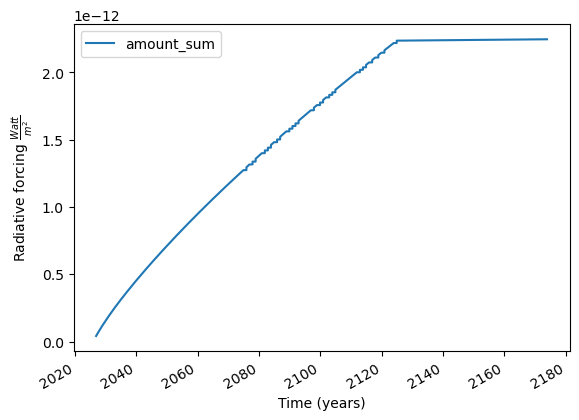

In [70]:
axes = characterized_dataframe_eps.plot(x="date", y="amount_sum")

axes.set_ylabel("Radiative forcing $\\frac{Watt}{m^{2}}$")
axes.set_xlabel("Time (years)")

Text(0.5, 0, 'Time (years)')

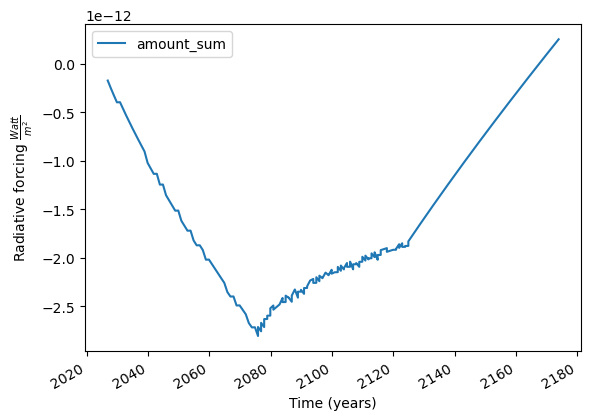

In [72]:
axes = characterized_dataframe_bio.plot(x="date", y="amount_sum")

axes.set_ylabel("Radiative forcing $\\frac{Watt}{m^{2}}$")
axes.set_xlabel("Time (years)")
